In [62]:
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import re
import spacy
from spacy.tokens import Token
from helper import *
import ast

#extracting dataframe paths
parent_folder = os.path.dirname(os.path.dirname(os.path.abspath("alt2.ipynb")))
char_data_path= os.path.join(parent_folder, "Data\\character.metadata.tsv")
plot_data_path= os.path.join(parent_folder, "Data\\resolved_texts_fastcoref.csv")
data_path= os.path.join(parent_folder, "Data\\Verb_Subject_Object.csv")
characters_list_path= os.path.join(parent_folder, "Data\\characters_list.csv")
interaction_path= os.path.join(parent_folder, "Data\\charA_action_charB.csv")
graph_path= os.path.join(parent_folder, "Data\\graph_df.csv")
char_metadata_path= os.path.join(parent_folder, "Data\\final_persona_char_movie_role.csv")
final_df_path= os.path.join(parent_folder, "Data\\final_merged_df.csv")

#building plot summaries dataframe
'''
ind={0:"Wikipedia movie ID", 1:"Freebase movie ID", 2:"Movie release date", 3:"Character name", 4:"Actor date of birth", 5:"Actor gender", 6:"Actor height", 7:"Actor ethnicity", 8:"Actor name", 9:"Actor age at movie release", 10:"Freebase character/actor map ID", 11:"Freebase character ID", 12:"Freebase actor ID"}
characters_df= pd.read_csv(char_data_path, delimiter="\t", header=None)
characters_df=characters_df.rename(columns=ind)
plots_df = pd.read_csv(plot_data_path, delimiter=',')
plots_df = plots_df.rename(columns={"wiki_id":"Wikipedia movie ID", "resolved_text":"Plot Summary"})
plots_df=plots_df.set_index("Wikipedia movie ID")
char_df = pd.read_csv(characters_list_path, delimiter=',')
char_df['characters'] = char_df['characters'].apply(ast.literal_eval)
char_df.set_index("Wikipedia movie ID", inplace=True)
df = pd.read_csv(data_path, delimiter=',')
df['Subject'] = df['Subject'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else np.nan)
df['Object'] = df['Object'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else np.nan)
df = df.merge(char_df, how='left', on='Wikipedia movie ID')
interaction_df = pd.read_csv(interaction_path, delimiter=',')
interaction_df['char A'] = interaction_df['char A'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else np.nan)
interaction_df['char B'] = interaction_df['char B'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else np.nan)
interaction_df['action'] = interaction_df['action'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else np.nan)
'''
movies = pd.read_csv(os.path.join(parent_folder, "Data\\movie.metadata.tsv"), sep='\t', header=None)
movies.columns = [
    'Wikipedia movie ID',
    'freebase_movie_id',
    'movie_name',
    'movie_release_date',
    'movie_box_office_revenue',
    'movie_runtime',
    'movie_languages',
    'movie_countries',
    'movie_genres'
]
movies['year'] = movies['movie_release_date'].str.extract('(\d{4})', expand=False)
movies['year'] = pd.to_numeric(movies['year'], downcast='integer')
movies['movie_box_office_revenue'] = pd.to_numeric(movies['movie_box_office_revenue'], errors='coerce')
movies['movie_runtime'] = pd.to_numeric(movies['movie_runtime'], errors='coerce')
# movie language distribution
query = re.compile(r'"(\w+) Language"')
movies['movie_languages'] = movies['movie_languages'].apply(lambda x: query.findall(x))
query = re.compile(r': "(.+)"')
movies['movie_countries'] = movies['movie_countries'].apply(lambda x: query.findall(x)[0] if query.findall(x) != [] else '')
query = re.compile(r': "(.+?)"')
movies['movie_genres'] = movies['movie_genres'].apply(lambda x: query.findall(x))
characters_df_full= pd.read_csv(os.path.join(parent_folder, "Data\\character.metadata.tsv"), sep='\t', header=None)
characters_df_full.columns = [
    'Wikipedia movie ID',
    'freebase_movie_id',
    'movie_release_date',
    'character_name',
    'actor_dob',
    'actor_gender',
    'actor_height',
    'actor_ethnicity',
    'actor_name',
    'actor_age',
    'freebase_character_map_1',
    'freebase_character_map_2',
    'freebase_character_map_3'
]
characters_df=characters_df_full[['Wikipedia movie ID','character_name', 'actor_dob','actor_gender','actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'freebase_character_map_1', 'freebase_character_map_2','freebase_character_map_3']]
final_df= pd.read_csv(final_df_path, delimiter=',')
final_df['action'] = final_df['action'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else np.nan) 
char_metadata_df= pd.read_csv(char_metadata_path, delimiter=',')
graph_df = pd.read_csv(graph_path, delimiter=',')
graph_df['action'] = graph_df['action'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else np.nan)

In [63]:
nlp = spacy.load("en_core_web_lg")

vocab_raw = set(graph_df['combined_action'].str.split().explode())

vocab_filtered = {word.lower() for word in vocab_raw if word.isalpha() and not word.isupper()}

lemmatizer = {word: token.lemma_ for word in vocab_filtered for token in nlp(word)}

vocab= set(lemmatizer.values())

word_vectors = {word: nlp(word).vector for word in vocab}

#lemmatize the action column
def lemmatize_action(action):
    return [lemmatizer.get(word, word) for word in action]

# Apply the lemmatizer function to create a new column 'lemmatized_action'
graph_df['lemmatized_action'] = graph_df['action'].apply(lemmatize_action)

In [52]:
from sklearn.metrics.pairwise import cosine_similarity

topics=['crime', 'love', 'fear', 'help', 'care', 'attack', 'grief', 'confuse', 'heartbreak', 'mentor','rivalry','collaborate','emotional','disputing','sadness','refusal','embarrassment']

for word in topics:
        centroid_vector = nlp(word).vector
        word_vectors_list = list(word_vectors.values())
        # Calculate cosine similarity with 'kill_vector' for each word in 'vocab'
        similarity_scores = cosine_similarity([centroid_vector], word_vectors_list)
        # Get the indices of words with high similarity
        similar_words_indices = similarity_scores.argsort()[0][::-1]
        # Extract the top N similar words
        top_n = 100
        cluster = [list(vocab)[i] for i in similar_words_indices[:top_n]]
        print(cluster)
        graph_df[word] = graph_df['lemmatized_action'].apply(lambda x: 1 if any(word in x for word in cluster) else 0)


['crime', 'criminal', 'homicide', 'murder', 'terrorism', 'violence', 'perpetrate', 'violent', 'terror', 'terrorist', 'perpetrator', 'murderous', 'corruption', 'terrorise', 'burglary', 'suicide', 'brutality', 'murderer', 'rape', 'conspiracy', 'robbery', 'theft', 'abuse', 'prosecute', 'prostitution', 'suspect', 'police', 'misdeed', 'terrorize', 'conviction', 'malfeasance', 'fraud', 'victimise', 'victim', 'extortion', 'gangster', 'harassment', 'accomplice', 'treason', 'trafficker', 'injustice', 'incriminate', 'homicidal', 'incident', 'corrupt', 'incarcerate', 'notorious', 'pedophile', 'torture', 'extrajudicial', 'corruptly', 'fugitive', 'racially', 'adultery', 'violently', 'gang', 'misconduct', 'policeman', 'assault', 'shoplifting', 'undercover', 'killer', 'indictment', 'punishment', 'racism', 'arrest', 'enforcer', 'justice', 'conspire', 'assassination', 'victimize', 'illegal', 'delinquent', 'brutally', 'suspecting', 'killing', 'indict', 'homosexuality', 'outlaws', 'vigilante', 'suspicion

<Axes: xlabel='actor_gender,actor_gender_charB'>

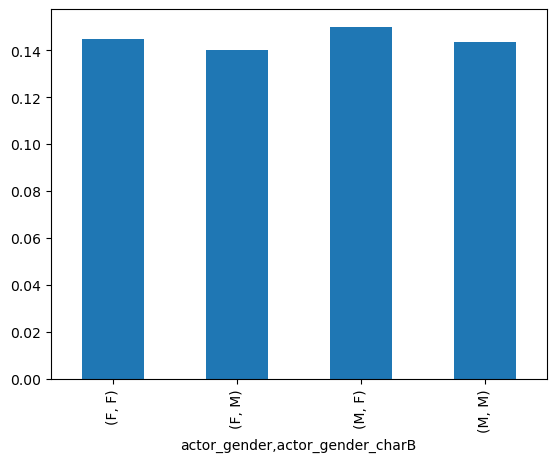

In [201]:
#histogram of crime across genres
final_df.groupby(['actor_gender', 'actor_gender_charB'])['help'].mean().plot(kind='bar')

In [ ]:
def replace_chars(row):
    characters= characters_df[characters_df['Wikipedia movie ID']==row['Wikipedia movie ID']]['character_name'].dropna().tolist()
    if not characters:
        return [row['char A'], row['char B']]
    i=0
    char_A_name=""
    char_B_name=""
    for chars in characters:
        if row['char A'] in chars:
            char_A_name = chars
            i+=1
        if row['char B'] in chars:
            char_B_name = chars
            i+=1
        if i==2:
            print("Done with row: ", row.name)
            return [char_A_name, char_B_name]
    if char_A_name=="":
        char_A_name = row['char A']
    if char_B_name=="":
        char_B_name = row['char B']
    print("Done with row: ", row.name)
    return [char_A_name, char_B_name]

graph_df=graph_df.merge(char_metadata_df[['Wikipedia movie ID', 'character', 'character_type']], how='left', left_on=['Wikipedia movie ID', 'char A'] , right_on=['Wikipedia movie ID', 'character'])
graph_df=graph_df.rename(columns={"character_type":"char A type"}).drop(columns=['character'])
graph_df=graph_df.merge(char_metadata_df[['Wikipedia movie ID', 'character', 'character_type']], how='left', left_on=['Wikipedia movie ID', 'char B'] , right_on=['Wikipedia movie ID', 'character'])
graph_df=graph_df.rename(columns={"character_type":"char B type"}).drop(columns=['character'])
graph_df['char A type'].fillna('side', inplace=True)
graph_df['char B type'].fillna('side', inplace=True)
temp_df=graph_df.apply(lambda row: replace_chars(row), axis=1)
real_char=pd.DataFrame(temp_df)
real_char[['charA', 'charB']] = real_char[0].apply(pd.Series)
real_char.drop(0, axis=1, inplace=True)
graph_df[['char A', 'char B']] = real_char[['charA', 'charB']]
graph_df = graph_df.merge(movies, how='left', on='Wikipedia movie ID', suffixes=('_graph', '_movies'))
graph_df = graph_df.merge(characters_df, how='left', left_on=['Wikipedia movie ID', 'char A'], right_on=['Wikipedia movie ID', 'character_name'], suffixes=('', '_charA'))
graph_df.columns = [f'{col}_charA' if col in characters_df.columns and col != 'Wikipedia movie ID' else col for col in graph_df.columns]
graph_df = graph_df.merge(characters_df, how='left', left_on=['Wikipedia movie ID', 'char B'], right_on=['Wikipedia movie ID', 'character_name'], suffixes=('', '_charB'))
graph_df.columns = [f'{col}_charB' if col in characters_df.columns and col != 'Wikipedia movie ID' else col for col in graph_df.columns]
graph_df.drop_duplicates(['Wikipedia movie ID', 'char A', 'action', 'char B'], inplace=True)
graph_df

Done with row:  0
Done with row:  1
Done with row:  2
Done with row:  3
Done with row:  4
Done with row:  5
Done with row:  6
Done with row:  7
Done with row:  8
Done with row:  9
Done with row:  10
Done with row:  11
Done with row:  12
Done with row:  13
Done with row:  14
Done with row:  15
Done with row:  16
Done with row:  17
Done with row:  18
Done with row:  26
Done with row:  27
Done with row:  28
Done with row:  29
Done with row:  30
Done with row:  31
Done with row:  32
Done with row:  33
Done with row:  34
Done with row:  35
Done with row:  36
Done with row:  37
Done with row:  38
Done with row:  39
Done with row:  40
Done with row:  41
Done with row:  42
Done with row:  43
Done with row:  44
Done with row:  45
Done with row:  46
Done with row:  47
Done with row:  48
Done with row:  49
Done with row:  50
Done with row:  51
Done with row:  52
Done with row:  54
Done with row:  55
Done with row:  56
Done with row:  57
Done with row:  58
Done with row:  59
Done with row:  60
Don

,Wikipedia movie ID,char A,action,char B,combined_action,lemmatized_action,char A type,char B type,freebase_movie_id_charA,movie_name,...,character_name_charB,actor_dob_charB,actor_gender_charB,actor_height_charB,actor_ethnicity_charB,actor_name_charB,actor_age_charB,freebase_character_map_1_charB,freebase_character_map_2_charB,freebase_character_map_3_charB
0,31186339,Peeta Mellark,"[reveal, love, for]",Katniss Everdeen,reveal love for,"[reveal, love, for]",side,side,/m/0gkz15s,The Hunger Games,...,Katniss Everdeen,1990-08-15,F,1.75,NaN,Jennifer Lawrence,21.0,/m/0gw7kv0,/m/0c01vfc,/m/02x0dzw
1,31186339,Katniss Everdeen,[discover],Peeta Mellark,discover,[discover],side,side,/m/0gkz15s,The Hunger Games,...,Peeta Mellark,1992-10-12,M,1.70,NaN,Josh Hutcherson,19.0,/m/0gw7kvp,/m/0c03gdc,/m/08wjf4
2,31186339,Rue,[call],Katniss Everdeen,call,[call],side,side,/m/0gkz15s,The Hunger Games,...,Katniss Everdeen,1990-08-15,F,1.75,NaN,Jennifer Lawrence,21.0,/m/0gw7kv0,/m/0c01vfc,/m/02x0dzw
3,31186339,Katniss Everdeen,[find],Rue,find,[find],side,side,/m/0gkz15s,The Hunger Games,...,Rue,1998-10-23,F,1.42,NaN,Amandla Stenberg,13.0,/m/0gwc398,/m/0gwc39c,/m/0gklrqy
4,31186339,Katniss Everdeen,"[comfort, the, dying]",Rue,comfort the dying,"[comfort, the, die]",side,side,/m/0gkz15s,The Hunger Games,...,Rue,1998-10-23,F,1.42,NaN,Amandla Stenberg,13.0,/m/0gwc398,/m/0gwc39c,/m/0gklrqy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130178,29046736,Hercules,[confront],Lucy,confront,[confront],side,side,/m/0dgskgp,I Don't Want to Be Born,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130179,29046736,Mandy,"[visit, 's]",Lucy,visit 's,"[visit, 's]",side,side,/m/0dgskgp,I Don't Want to Be Born,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130180,29046736,Lucy,"[pay, a, visit]",Tommy,pay a visit,"[pay, a, visit]",side,side,/m/0dgskgp,I Don't Want to Be Born,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130181,1096473,Leo,[cast],Sergius,cast,[cast],side,side,/m/045pct,The Last Command,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


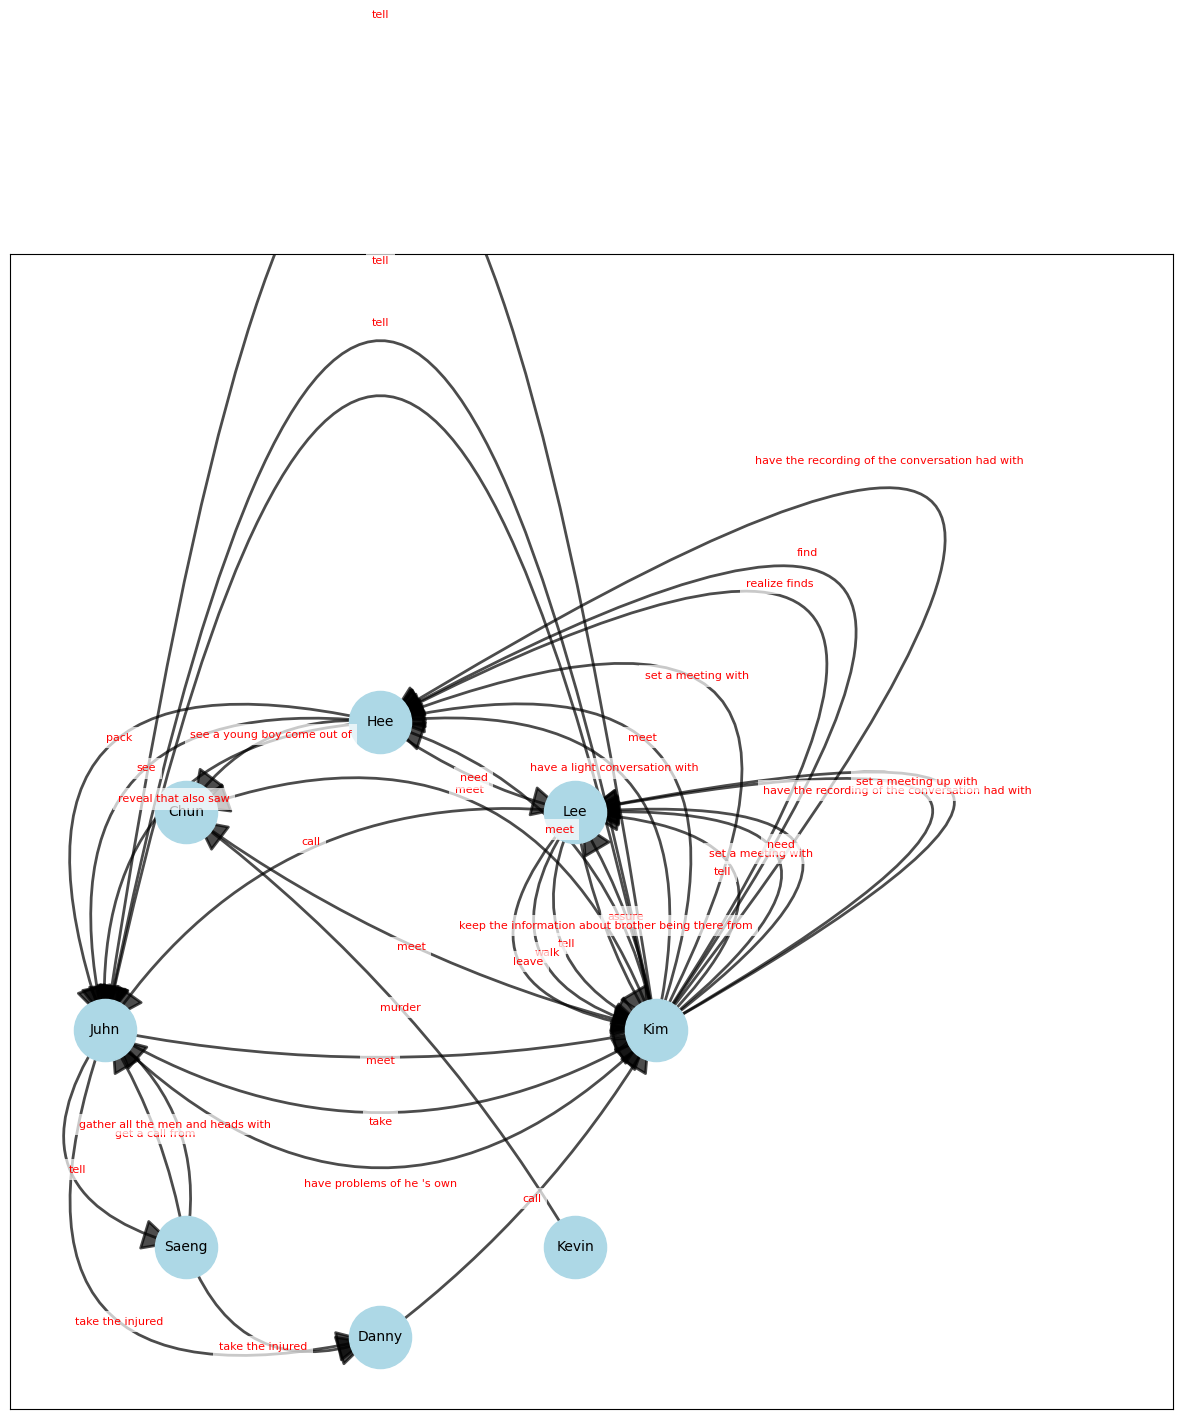

In [154]:
id=graph_df.groupby('Wikipedia movie ID').count().sort_values('action', ascending=False).index[90]
data = graph_df[graph_df['Wikipedia movie ID']==id]
plt.figure(figsize=(15, 15))
G=nx.MultiDiGraph()

def edge_center_coordinates(edge, curvature, pos):
    start_x, start_y = pos[edge[0]]
    end_x, end_y = pos[edge[1]]
    
    # Calculate the control point coordinates for the curved edge
    control_x = 0.5 * (start_x + end_x) + curvature * (end_y - start_y)
    control_y = 0.5 * (start_y + end_y) - curvature * (end_x - start_x)
    
    # Calculate the Bezier curve parameters
    t = 0.5  # Midpoint of the curve
    bx = (1 - t)**2 * start_x + 2 * (1 - t) * t * control_x + t**2 * end_x
    by = (1 - t)**2 * start_y + 2 * (1 - t) * t * control_y + t**2 * end_y
    
    return bx, by

for subj in data["char A"].unique():
    G.add_node(subj, color="lightblue", node_size=2000)
    i=1
    for verb, obj in data[data["char A"]==subj][["combined_action", "char B"]].itertuples(index=False):
        G.add_edge(subj, obj, label=verb, curvature=i/10)
        i+=2

pos = nx.circular_layout(G)

# Draw nodes separately
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
# Draw node labels if needed
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Draw the graph with curved edges based on the 'curvature' attribute
for edge in G.edges(data=True):
    edge_data = edge[2]
    label = edge_data['label']
    curvature = edge_data.get('curvature', 0.1)  # Default curvature if 'curvature' is not present
    #draw edges
    nx.draw_networkx_edges(G, pos, edgelist=[(edge[0], edge[1])], connectionstyle=f'arc3,rad={curvature}', edge_color='black', width=2, alpha=0.7, label=label, arrows=True, arrowsize=50, arrowstyle='-|>')
    center_coordinates = edge_center_coordinates(edge, curvature, pos)
    plt.text(center_coordinates[0], center_coordinates[1], label, color='red', fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Show the plot
plt.show()

# Pipeline
this code snippet was used to create Verb_Subject_Object.csv and character_list.csv

In [ ]:
final_df=pd.DataFrame(columns=["Wikipedia movie ID", "Sentence", "Verb", "Subject", "Object"])
char_df=pd.DataFrame(columns=["Wikipedia movie ID", "characters"])
nlp = spacy.load("en_core_web_lg")

for i, id in enumerate(plots_df.index):
    sent_df=pd.DataFrame(columns=["Wikipedia movie ID", "Sentence", "Verb", "Subject", "Object", "nsubj", "nsubjpass", "dobj", "agent", "ccomp"])
    plot=plots_df.iloc[i]["Plot Summary"]
    doc= nlp(plot)
    characters = get_characters(doc)
    print(characters)
    char_values = {"Wikipedia movie ID": id,"characters": characters}
    char_df.loc[len(char_df)] = char_values
    sent_num = 0
    for sent in doc.sents:
        # print the verb and all its children and their dependency relations
        sent_num += 1
        for token in sent:
            if token.pos_ == "VERB":
                # Create a dictionary with the values to be assigned
                values = {"Wikipedia movie ID": id,"Sentence": sent_num, "Verb": token.lemma_}
                for child in token.children:
                    if child.dep_ in sent_df.columns:
                        values[child.dep_] = get_all_children(child)
                # Append the dictionary as a new row to sent_df
                sent_df.loc[len(sent_df)] = values
    sent_df["Object"] = sent_df["dobj"].combine_first(sent_df["nsubjpass"]).combine_first(sent_df["ccomp"])
    sent_df.drop(columns=["dobj", "nsubjpass", "ccomp"], inplace=True)
    sent_df["Subject"] = sent_df["nsubj"].combine_first(sent_df["agent"])
    sent_df.drop(columns=["nsubj", "agent"], inplace=True)
    sent_df["Object"] = sent_df["Object"].apply(replace_tokens_with_refs)
    sent_df["Subject"] = sent_df["Subject"].apply(replace_tokens_with_refs)
    final_df=pd.concat([final_df, sent_df], ignore_index=True)
    if (i+1) % 5000 == 0:
        final_df.to_csv(f'Verb_Subject_Object_{i}.csv', index=False)
        char_df.to_csv(f'characters_{i}.csv', index=False)
        char_df=pd.DataFrame(columns=["Wikipedia movie ID", "characters"])
        final_df = pd.DataFrame(columns=["Wikipedia movie ID", "Sentence", "Verb", "Subject", "Object"])
    print("Done with movie : ", i)

char_df.to_csv('characters_end.csv', index=False)
final_df.to_csv('Verb_Subject_Object_end.csv', index=False)
df=final_df.merge(char_df, how='left', on='Wikipedia movie ID')

this code snippet was used to create transform the charA_action_charB.csv and charA_action_charB_filtered.csv and graph_df.csv

In [ ]:
filtered_df = df[df.apply(lambda row: (isinstance(row["Subject"], list) and any(elem in row["characters"] for elem in row["Subject"])) or (isinstance(row["Object"], list) and any(elem in row["characters"] for elem in row["Object"])), axis=1)]
filtered_df.reset_index(drop=True, inplace=True)

def transform_row(row):
    verb = [row["Verb"]] if pd.notna(row["Verb"]) else []
    subject = row["Subject"] if isinstance(row["Subject"], list) else []
    obj = row["Object"] if isinstance(row["Object"], list) else []
    characters= row["characters"] if isinstance(row["characters"], list) else []
    char_A = set([char for char in subject if  char in characters])
    char_B = set([char for char in obj if char in characters])
    action = []
    for word in (verb + obj):
        if word in char_A:
            continue
        elif word in characters:
            break
        action.append(word)
    print("done with index", row.name)
    return pd.Series({"Wikipedia movie ID": row["Wikipedia movie ID"],"char A": list(char_A), "action": action, "char B": list(char_B)})

transformed_df = filtered_df.apply(transform_row, axis=1)
graph_df=transformed_df[(transformed_df["char A"].apply(lambda x: len(x) > 0)) & (transformed_df["char B"].apply(lambda x: len(x) > 0)) & (transformed_df["char A"]!=transformed_df["char B"])]
graph_df=graph_df.explode('char B').explode('char A')
graph_df=graph_df[graph_df['char A']!=graph_df['char B']].reset_index(drop=True)
graph_df['combined_action'] = graph_df['action'].apply(lambda x: ' '.join(x))

In [ ]:
transformed_df.to_csv('charA_action_charB.csv', index=False)
graph_df.to_csv('graph_df.csv', index=False)